**UNIVERSIDADE DE SÃO PAULO**<br>
**MBA DATA SCIENCE & ANALYTICS USP/ESALQ**<br>
**ÁRVORES, REDES E ENSEMBLE MODELS**<br>
**Prof. João Fernando Serrajordia Rocha de Melo**<br>
Aluna: Luiza Batista Laquini<br>
Turma: DSA 241<br>

*coding: utf-8*

In [122]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, roc_curve, roc_auc_score
from funcoes_ajuda import descritiva, avalia_clf

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [123]:
# Definir uma semente aleatória para reprodutibilidade
np.random.seed(42)
random.seed(42)

# Gerar as variáveis simuladas com correlação
idade = np.random.randint(18, 71, 10000)

# Gerar variáveis correlacionadas usando a função multivariada normal
mean_values = [5000, 2000, 0.5, 5]  # Médias das variáveis
correlation_matrix = np.array([
    [1, 0.3, 0.2, -0.1],
    [0.3, 1, -0.1, 0.2],
    [0.2, -0.1, 1, 0.4],
    [-0.1, 0.2, 0.4, 1]
])  # Matriz de correlação

# Gerar dados simulados
simulated_data = np.random.multivariate_normal(mean_values, correlation_matrix, 10000)

renda = simulated_data[:, 0]
divida = simulated_data[:, 1]
utilizacao_credito = np.clip(simulated_data[:, 2], 0, 1)  # Limita a utilização de crédito entre 0 e 1
consultas_recentes = np.maximum(simulated_data[:, 3], 0)  # Garante que o número de consultas recentes seja não negativo

# Gerar função linear das variáveis explicativas
preditor_linear = -7 - 0.01 * idade - 0.0002 * renda + 0.003 * divida - 3 * utilizacao_credito + 0.5 * consultas_recentes

# Calcular probabilidade de default (PD) usando a função de link logit
prob_default = 1 / (1 + np.exp(-preditor_linear))

# Gerar inadimplência como variável Bernoulli com base na probabilidade de default
inadimplencia = np.random.binomial(1, prob_default, 10000)

# Criar dataframe
dados = pd.DataFrame({
    'idade': idade,
    'renda': renda,
    'divida': divida,
    'utilizacao_credito': utilizacao_credito,
    'consultas_recentes': consultas_recentes,
    'inadimplencia': inadimplencia
})

print(dados.head())

   idade        renda       divida  utilizacao_credito  consultas_recentes  \
0     56  5001.087921  1999.455126             0.95862            4.875699   
1     69  5000.719625  2000.810295             1.00000            6.445579   
2     46  4999.716997  2001.196934             0.00000            5.101072   
3     32  5001.297920  2000.322691             0.69576            5.748065   
4     60  4999.152684  2000.239878             1.00000            5.304662   

   inadimplencia  
0              0  
1              0  
2              1  
3              0  
4              0  


In [124]:
# Categorizar a idade
kbin = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
dados['idade_cat'] = kbin.fit_transform(dados[['idade']])

def descritiva2(var1, var2, df):
    cross_tab = pd.crosstab(df[var1], df[var2], normalize='index')
    print(cross_tab)

descritiva2('idade_cat', 'inadimplencia', dados)

print(dados.head())

inadimplencia         0         1
idade_cat                        
0.0            0.703339  0.296661
1.0            0.725639  0.274361
2.0            0.752874  0.247126
3.0            0.761631  0.238369
4.0            0.773301  0.226699
   idade        renda       divida  utilizacao_credito  consultas_recentes  \
0     56  5001.087921  1999.455126             0.95862            4.875699   
1     69  5000.719625  2000.810295             1.00000            6.445579   
2     46  4999.716997  2001.196934             0.00000            5.101072   
3     32  5001.297920  2000.322691             0.69576            5.748065   
4     60  4999.152684  2000.239878             1.00000            5.304662   

   inadimplencia  idade_cat  
0              0        3.0  
1              0        4.0  
2              1        2.0  
3              0        1.0  
4              0        4.0  


In [125]:
dados.to_parquet('data/exercicio.parquet')

#####################################################################################
# Agora é a sua vez: Ajuste uma árvore de decisão, e explore os recursos que fizemos 
# ao longo da aula nesta base de dados ;)

### Resolução

In [126]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   idade               10000 non-null  int32  
 1   renda               10000 non-null  float64
 2   divida              10000 non-null  float64
 3   utilizacao_credito  10000 non-null  float64
 4   consultas_recentes  10000 non-null  float64
 5   inadimplencia       10000 non-null  int32  
 6   idade_cat           10000 non-null  float64
dtypes: float64(5), int32(2)
memory usage: 468.9 KB


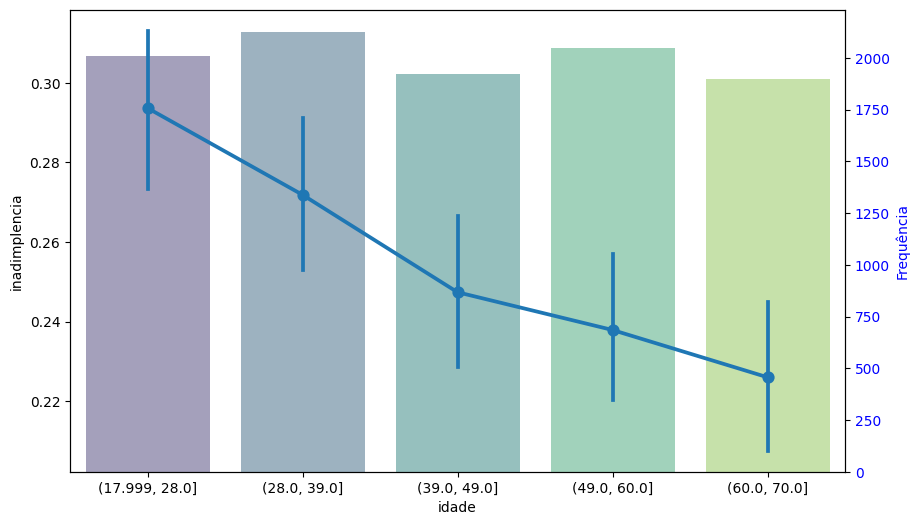

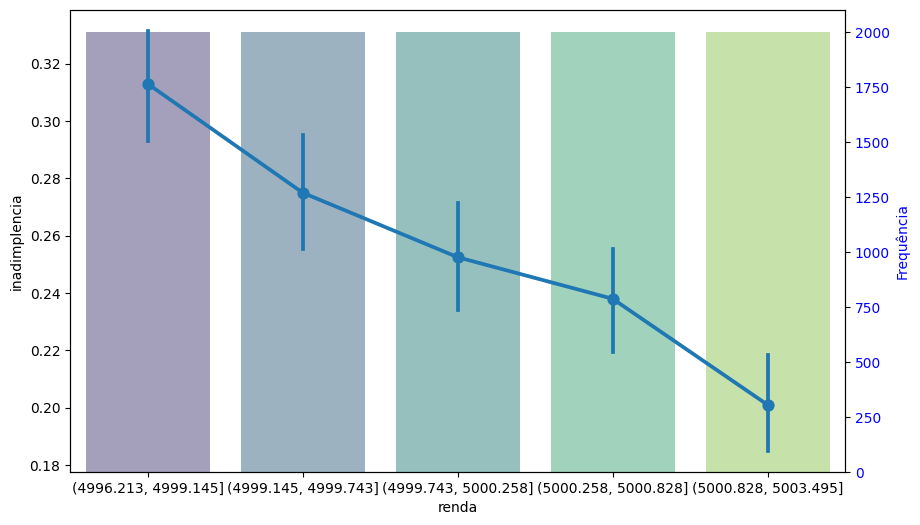

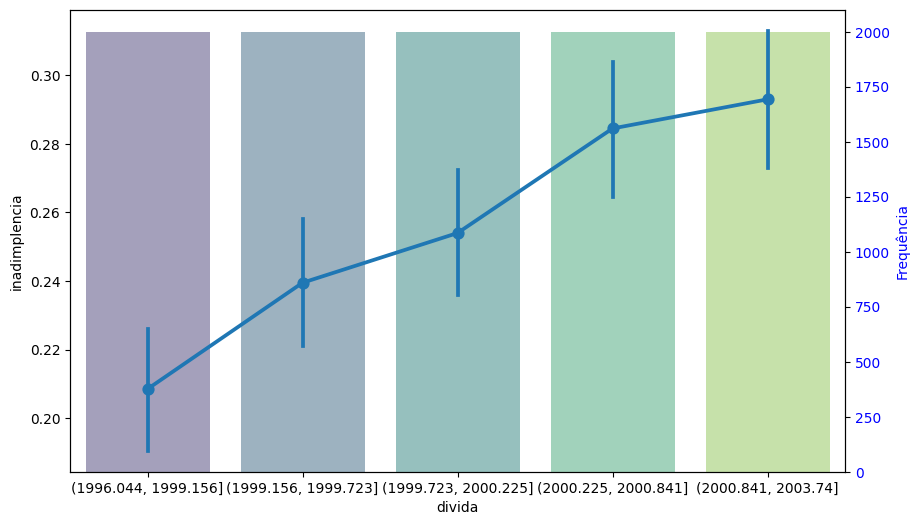

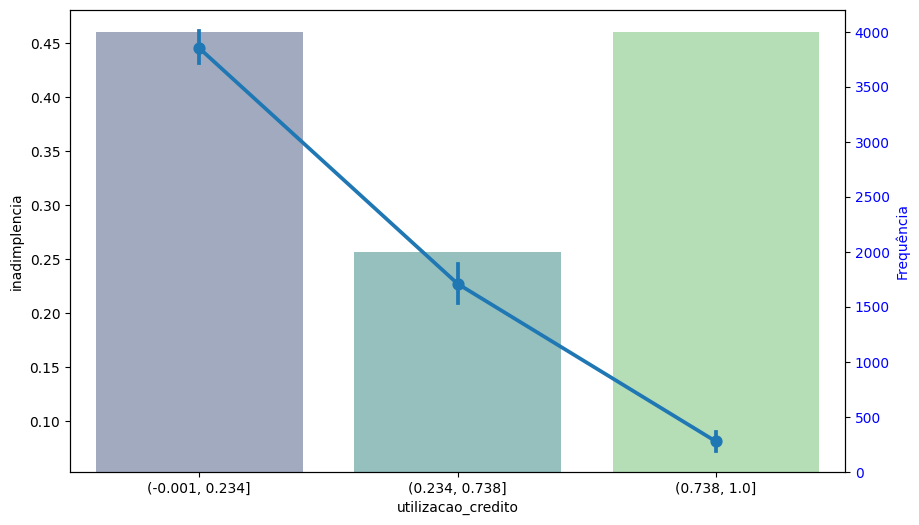

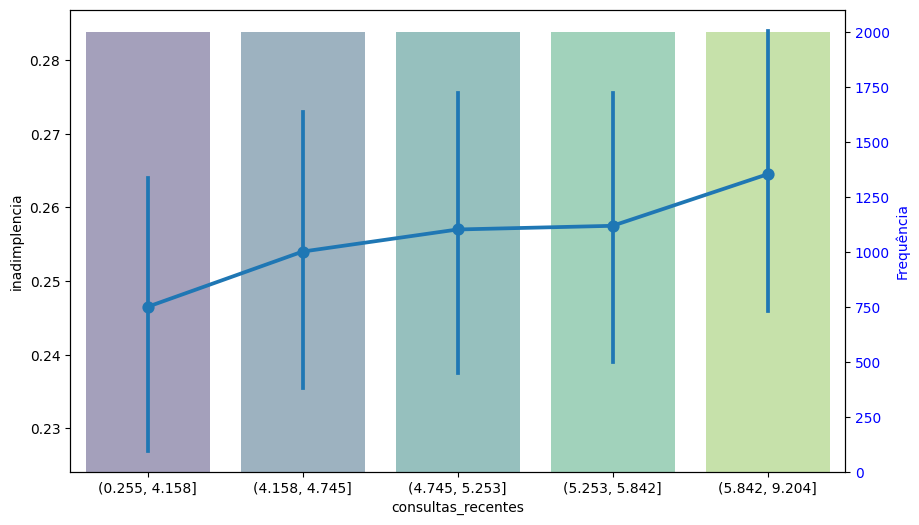

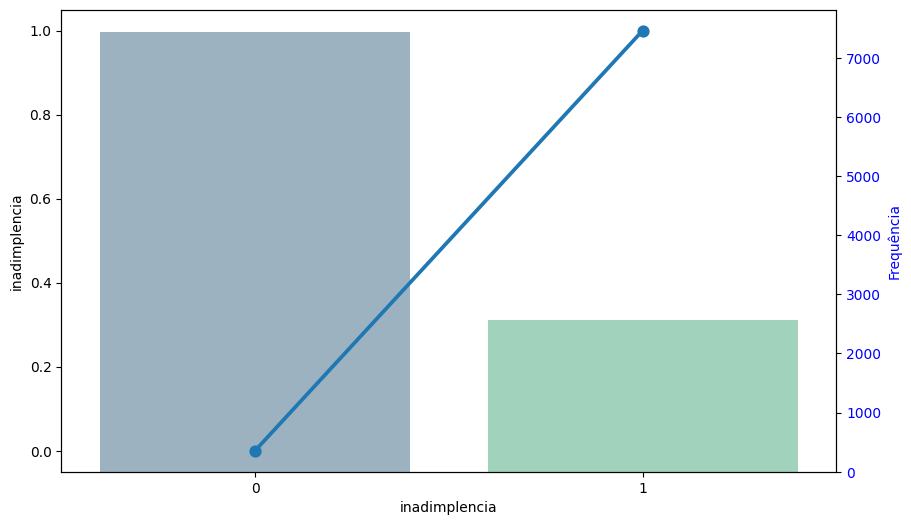

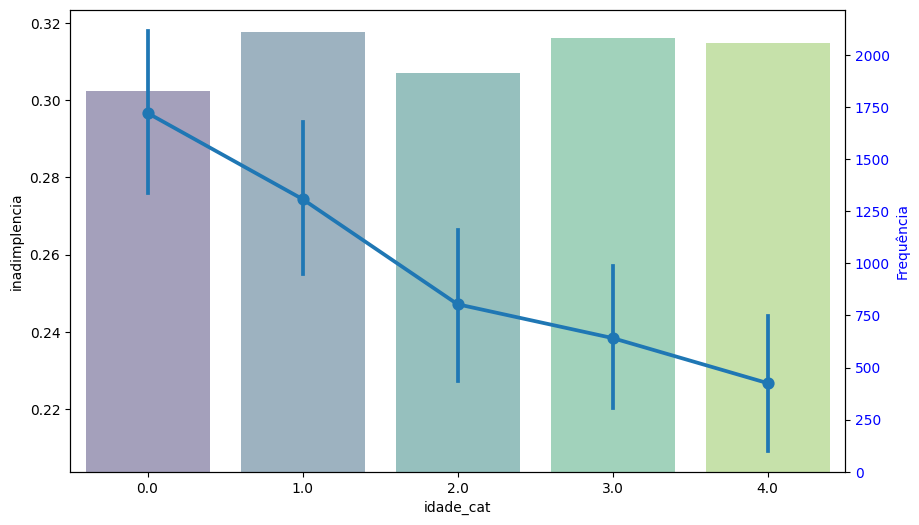

In [127]:
for var in dados.columns:
    descritiva(dados, var=var, vresp = 'inadimplencia')

In [128]:
#  Árvore de decisão
X = dados.drop(columns = ['inadimplencia'])
y = dados['inadimplencia']

# Dividir os dados em 80% treino e 20% teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estanciar a classe da árvore de decisão em um objeto chamado arvore
# Este objeto não possui os dados em um primeiro momento
# Mas ela possui todos os atributos e métodos que precisaremos
arvore = DecisionTreeClassifier(criterion='gini', max_depth = 4, random_state=42)

# Treinar o modelo com o método .fit().
arvore.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

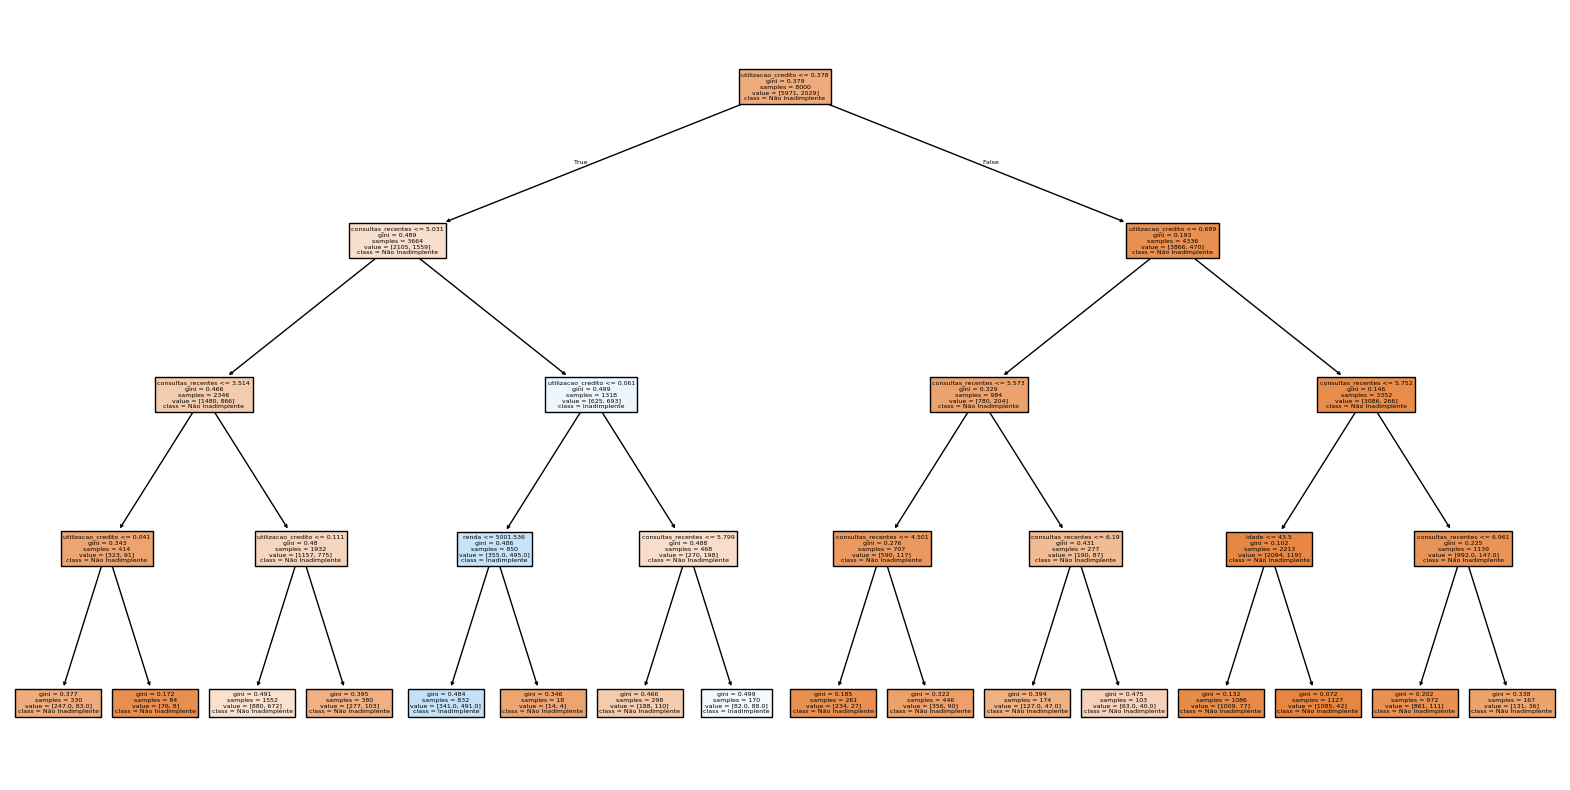

In [129]:
#  Plotar a árvore
plt.figure(figsize=(20, 10))
plot_tree(arvore, feature_names=X_train.columns.tolist(), class_names=['Não Inadimplente', 'Inadimplente'], filled=True)
plt.show()

In [130]:
# Calculando acurácia e matriz de confusão

# Vamos avaliar o modelo com algumas funções próprias do Scikit-Learn
# A função confudion_matrix faz basicamente a comparação acima
cm = confusion_matrix(y_test, arvore.predict(X_test))
# accuracy_score calcula o percentual de acertos
ac = accuracy_score(y_test, arvore.predict(X_test))
# Essa função pondera para forçar a distribuição da target como uniforme
bac = balanced_accuracy_score(y_test, arvore.predict(X_test))

print(f'\nA acurácia da árvore é: {ac:.1%}')
print(f'A acurácia balanceada da árvore é: {bac:.1%}')


A acurácia da árvore é: 75.6%
A acurácia balanceada da árvore é: 60.5%


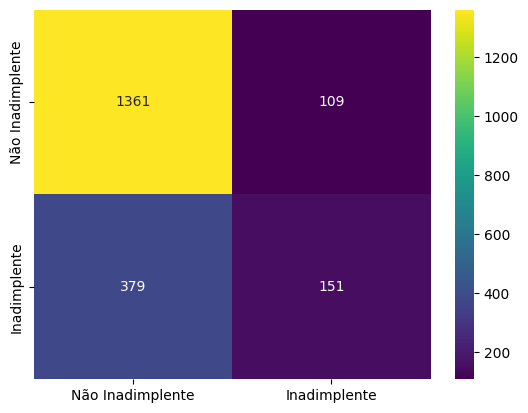

In [131]:
# Visualização gráfica
sns.heatmap(cm, 
            annot=True, fmt='d', cmap='viridis', 
            xticklabels=['Não Inadimplente', 'Inadimplente'], 
            yticklabels=['Não Inadimplente', 'Inadimplente'])
plt.show()

In [132]:
# Relatório de classificação do Scikit
print('\n', classification_report(y_test, arvore.predict(X_test)))


               precision    recall  f1-score   support

           0       0.78      0.93      0.85      1470
           1       0.58      0.28      0.38       530

    accuracy                           0.76      2000
   macro avg       0.68      0.61      0.62      2000
weighted avg       0.73      0.76      0.72      2000



In [133]:
def plot_roc_curve(model, X, y):
  # Prevendo probabilidades para o conjunto de teste
  y_probs = model.predict_proba(X)[:, 1]  # Probabilidades para a classe positiva (1)

  # Calculando a curva ROC
  fpr, tpr, thresholds = roc_curve(y, y_probs)
  roc_auc = roc_auc_score(y, y_probs)

  # Exibindo os resultados
  print(f"Área sob a curva ROC (AUC): {roc_auc:.2f}")

  # Plotando a curva ROC
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
  plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Linha de referência
  plt.xlabel('Taxa de Falsos Positivos (FPR)')
  plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
  plt.title('Curva ROC')
  plt.legend(loc='lower right')
  plt.grid()
  plt.show()

CURVA ROC TREINO
Área sob a curva ROC (AUC): 0.78


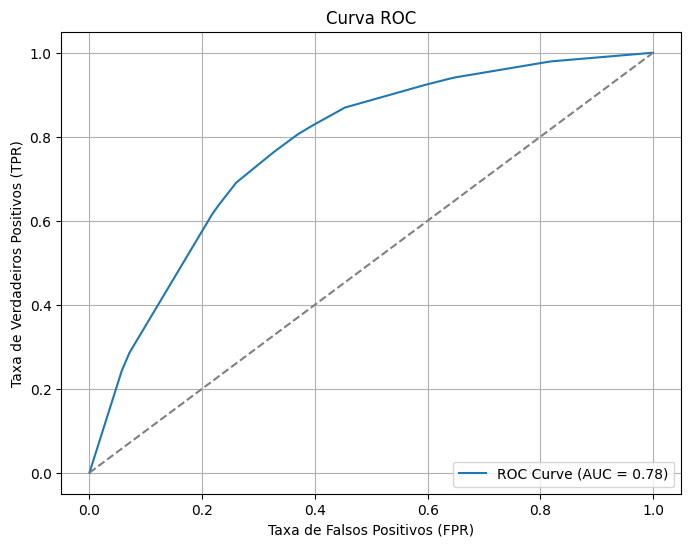

CURVA ROC TESTE
Área sob a curva ROC (AUC): 0.76


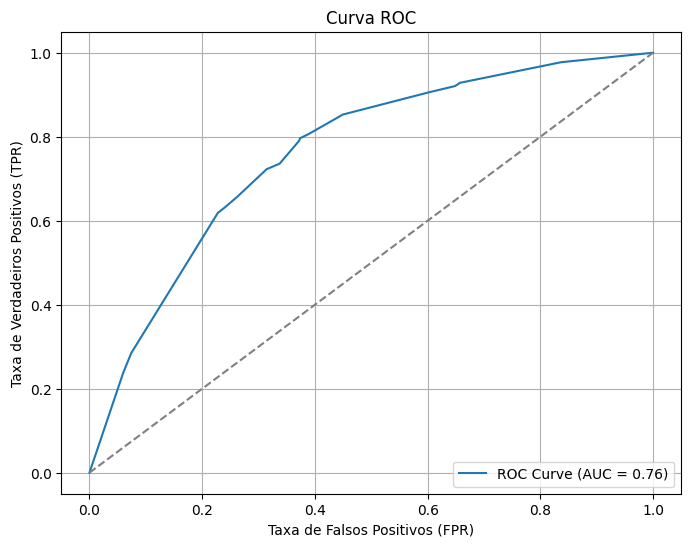

In [134]:
print("CURVA ROC TREINO")
plot_roc_curve(arvore, X_train, y_train)
print("CURVA ROC TESTE")
plot_roc_curve(arvore, X_test, y_test)